In [1]:
# Import necessary modules
#pip install langdetect
import requests
from bs4 import BeautifulSoup
import numpy as np
import re
import langdetect 
import pandas as pd
import nltk
from langdetect import detect
import matplotlib.pyplot as plt
import pandas as pd

final_data = pd.read_csv(r"C:\Users\lisbe\OneDrive\11. Semester\Social Data Science\Modules\final_data.csv", index_col=0).reset_index()
df = final_data.copy()

#Define todays date and enddate for data
from datetime import date
today = date.today().strftime("%Y%m%d") # to get format 20080101
start = '20100101'


#Make lists of dates, areas, categories and subcategories
#all unique dates
dates = pd.DataFrame(pd.date_range(start=start, end=today, freq='D').strftime("%Y%m%d").tolist())
dates = dates.iloc[pd.to_datetime(dates.index).argsort()] #sort
dates.columns = ['Date']

#all unique month-year
months = pd.DataFrame(pd.date_range(start=start, end=today, freq='MS').strftime("%b-%Y").tolist()) 
months = months.iloc[pd.to_datetime(months.index).argsort()] #sort
months.columns = ['Month-Year']
#monthlist = [str(date).strip("()").strip("datetime.date").replace(',','') for date in monthlist]

#all unique areas
areas = pd.DataFrame(np.unique(final_data['Geographical Area']))
areas.columns = ['Geographical Area']

#all unique categories
categories = pd.DataFrame(np.unique(final_data['Job Category']))
categories.columns = ['Job Category']

#all unique subcategories
subcategories = pd.DataFrame(np.unique(final_data['Job Subcategory']))
subcategories.columns = ['Job Subcategory']

'''#Figure 1a shows the actual number of remote job postings on Jobindex at a given point in time in the period 2015-2020. 
The bars are further split into job categories (industries).'''

#Count the number of remote job postings per month-year
total_remote_date = pd.DataFrame(final_data.groupby('Month-Year')['Remote'].sum()).reset_index()
total_remote_date.columns = ['Month-Year','Remote Postings Published']

In [2]:
# We want a time series with two columns : 'ds' and 'y' where ds is the date

total_remote_date['Month-Year']= pd.to_datetime(total_remote_date['Month-Year'])
total_remote_date.columns = ['ds','y']
total_remote_date.sort_values(by=['ds'], ascending=True).reset_index(drop=True)

ts = total_remote_date.sort_values(by=['ds'], ascending=True).reset_index(drop=True)[:121]

In [3]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

Importing plotly failed. Interactive plots will not work.


In [26]:
prophet = Prophet(growth='linear')
ts_complete = total_remote_date.sort_values(by=['ds'], ascending=True).reset_index(drop=True)[:127]
prophet.fit(ts_complete)
cv_results = cross_validation(prophet, initial = '730 days', horizon='90 days')
df_p = performance_metrics(cv_results)
df_p

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 67 forecasts with cutoffs between 2012-02-14 00:00:00 and 2020-04-02 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


,horizon,mse,rmse,mae,mape,mdape,coverage
0,8 days,397.102543,19.927432,18.091138,0.169789,0.153252,0.526316
1,9 days,389.860685,19.744890,17.807468,0.167796,0.153252,0.526316
2,10 days,427.784996,20.682964,18.514470,0.186256,0.165974,0.500000
3,11 days,414.322337,20.354909,18.306752,0.181036,0.153252,0.486842
4,12 days,400.360588,20.009013,17.173370,0.158401,0.119599,0.552632
...,...,...,...,...,...,...,...
74,86 days,655.322581,25.599269,20.914479,0.180938,0.142144,0.403509
75,87 days,461.689177,21.486954,17.431969,0.149662,0.120682,0.473684
76,88 days,410.979192,20.272622,16.984836,0.133983,0.120682,0.473684
77,89 days,383.037723,19.571350,16.274661,0.128651,0.120682,0.526316


In [20]:
prophet_2 = Prophet(growth='linear')
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cv_results, metric='rmse')

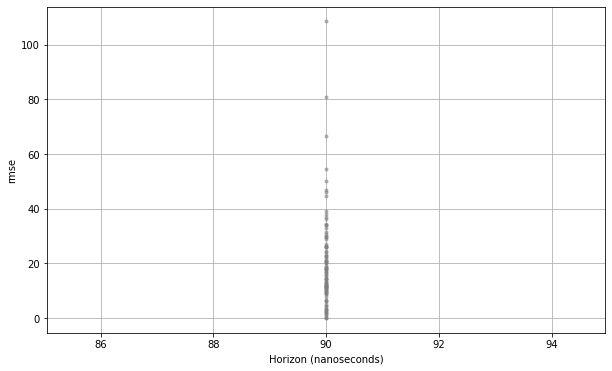

In [ ]:
# Fitting the model to our data set
model = Prophet()
model.fit(ts)

# Creating an empty data set for forecasting

from pandas import DataFrame
future= pd.date_range('2016-01-01','2017-01-01', freq='1M')-pd.offsets.MonthBegin(1)
future = future.tolist()

future = DataFrame(future,columns=['ds'])
future['ds'] = pd.to_datetime(future['ds'])
predict_2016 = model.predict(future)

# Making forecast for february to july 2020

forecast= pd.date_range('2010-01-01','2020-08-01', freq='1M')-pd.offsets.MonthBegin(1)
forecast = forecast.tolist()

forecast = DataFrame(forecast,columns=['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast = model.predict(forecast)

true_data = total_remote_date.sort_values(by=['ds'], ascending=True).reset_index(drop=True)[:127]
forecast = forecast[['ds','yhat','yhat_lower','yhat_upper']]

# create figure and axis objects with subplots()

plot = pd.merge(true_data, forecast, on='ds', how='right')
ticks= pd.date_range('2010-12-01','2021-08-01', freq='1Y')-pd.offsets.MonthBegin(12)
fig,ax = plt.subplots(figsize=(11,7))
ax.plot(plot['ds'],plot['yhat'], color="red", linewidth=0.9, label = 'Predicted')
ax.plot(plot['ds'],plot['y'], color="blue", linewidth=0.9, label = 'Actual')
ax.set_xlabel("Month-Year",fontsize=15)
ax.set_ylabel("Monthly Remote Job Listings", fontsize=15)
plt.xticks(ticks,fontsize=12,rotation=20)
plt.yticks(fontsize=12)
ax.legend(fontsize=15)
plt.savefig('forecast.png')


In [ ]:
# Fitting the model to our data set
model = Prophet()
model.fit(ts)

